In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc,classification_report, accuracy_score
import nltk
import re
import string
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Musical_instruments_reviews.csv to Musical_instruments_reviews.csv


In [ ]:
import io
reviews_amazon = pd.read_csv(io.BytesIO(uploaded['Musical_instruments_reviews.csv']))

In [ ]:
reviews_amazon.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
reviews_amazon.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [ ]:
reviews_amazon['reviewText'].fillna('', inplace = True)

In [ ]:
reviews_amazon =reviews_amazon.drop(columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis =1)

In [ ]:
reviews_amazon.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [ ]:
reviews_amazon['combinedText'] = reviews_amazon['summary'] + ' ' +reviews_amazon['reviewText']

In [ ]:
reviews_amazon.head()

,reviewText,overall,summary,combinedText
0,"Not much to write about here, but it does exac...",5.0,good,"good Not much to write about here, but it does..."
1,The product does exactly as it should and is q...,5.0,Jake,Jake The product does exactly as it should and...
2,The primary job of this device is to block the...,5.0,It Does The Job Well,It Does The Job Well The primary job of this d...
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,No more pops when I record my vocals. This pop...


In [ ]:
reviews_amazon =reviews_amazon.drop(columns=['reviewText', 'summary'], axis =1)

In [ ]:
reviews_amazon['overall'] = np.where(reviews_amazon['overall']>=4, 'good', 'bad')

In [ ]:
reviews_amazon.head()

,overall,combinedText
0,good,"good Not much to write about here, but it does..."
1,good,Jake The product does exactly as it should and...
2,good,It Does The Job Well The primary job of this d...
3,good,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,good,No more pops when I record my vocals. This pop...


In [ ]:
reviews_amazon['overall'].value_counts()

good    9022
bad     1239
Name: overall, dtype: int64

In [ ]:
cleanup_re = re.compile('[^a-z]+')
def clean(sentence): 
  sentence = str(sentence)
  sentence = sentence.lower()
  sentence = cleanup_re.sub(' ', sentence).strip()
  return sentence
reviews_amazon['combinedText'] = reviews_amazon['combinedText'].apply(clean)

In [ ]:
X_train = reviews_amazon.sample(frac = 0.8, random_state=200)
X_test = reviews_amazon.drop(X_train.index)

In [ ]:
from fastai import *
from fastai.text import *
import os

installing hugging face transformers

In [ ]:
%%bash
pip install -q transformers

In [ ]:
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

In [ ]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.8.0


In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert':(AlbertForSequenceClassification,AlbertTokenizer, AlbertConfig)
}

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
# Parameters
seed = 10
use_fp16 = True
bs = 4

model_type = 'roberta'
pretrained_model_name = 'roberta-large'

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(seed)

Using Tokenizer Class

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Converting Text to Features

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

Padding Sequence

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
data_transclas = (TextList.from_df(X_train, cols=['combinedText'], processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'overall').databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Checking the Tokens

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_transclas.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġthe Ġbest Ġsound Ġsolid Ġstate Ġtechnology Ġhas Ġto Ġoffer Ġi Ġown Ġseveral Ġtube Ġamp Ġcombo Ġand Ġhalf Ġstack Ġhowever Ġi Ġwanted Ġa Ġsmaller Ġlighter Ġcombo Ġthat Ġwould Ġbe Ġeasy Ġto Ġtransport Ġand Ġwouldn Ġt Ġneed Ġany Ġpedals Ġbut Ġwould Ġalso Ġbe Ġloud Ġenough Ġto Ġpractice Ġwith Ġa Ġdrummer Ġthe Ġline Ġspider Ġiv Ġwatt Ġcombo Ġwas Ġthe Ġperfect Ġsolution Ġup Ġto Ġthis Ġpoint Ġi Ġhaven Ġt Ġbeen Ġvery Ġimpressed Ġby,good
<s> Ġfinally Ġfound Ġmy Ġcap o Ġthis Ġone Ġis Ġit Ġlook Ġno Ġfurther Ġi Ġhave Ġbeen Ġplaying Ġguitar Ġfor Ġmore Ġyears Ġthan Ġi Ġcare Ġto Ġadmit Ġokay Ġi Ġbought Ġa Ġtele caster Ġbrand Ġnew Ġback Ġthen Ġstill Ġhave Ġit Ġand Ġlove Ġit Ġi Ġhave Ġa Ġlot Ġof Ġdifferent Ġguitars Ġmostly Ġelectric Ġand Ġac oust ics Ġon Ġmy Ġelect rics Ġi Ġlove Ġextra Ġlight Ġgauge Ġstrings Ġonly Ġabout Ġof Ġus Ġdo,good
<s> Ġconsiderable Ġdisappointment Ġi Ġpurchased Ġthis Ġinstrument Ġbrand Ġnew Ġon Ġan Ġimpulse Ġwhim Ġdue Ġto Ġa Ġmanagers Ġchoice Ġsale Ġat Ġa Ġlocal Ġmusic Ġshop Ġthat Ġi Ġsimply Ġcould Ġnot Ġignore Ġit Ġwas Ġbrand Ġnew Ġun opened Ġin Ġbox Ġthey Ġallowed Ġme Ġto Ġexamine Ġit Ġprior Ġto Ġpurchase Ġin Ġthat Ġenvironment Ġi Ġthought Ġit Ġa Ġnice Ġinstrument Ġhowever Ġit Ġcan Ġbe Ġdifficult Ġto Ġproperly Ġexamine Ġan Ġinstrument Ġin Ġa Ġbusy Ġstore,bad
<s> Ġu k ule le Ġstraps Ġare Ġa Ġhard Ġto Ġfind Ġthing Ġu k ule le Ġstraps Ġare Ġa Ġrare Ġthing Ġand Ġi Ġve Ġyet Ġto Ġfind Ġthe Ġperfect Ġone Ġthis Ġone Ġgets Ġclose Ġnot Ġall Ġu ke Ġplayers Ġuse Ġstraps Ġsome Ġdo Ġand Ġsome Ġdon Ġt Ġpur ists Ġsay Ġnot Ġto Ġuse Ġone Ġand Ġthat Ġusing Ġone Ġmakes Ġyou Ġlook Ġlazy Ġor Ġinexperienced Ġhowever Ġi Ġhave Ġtwo Ġacoustic Ġelectric,good


In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_transclas.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([4, 512])
tensor([[    0,    71,    10,  ...,  2178,    13,     2],
        [    0,   372,   923,  ...,     7,     5,     2],
        [    0,    10,  2579,  ...,   454,    51,     2],
        [    0, 21762,    15,  ...,   526,    16,     2]])


Custom Transformer Model with attention mask (Need to understand More)

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

Tweaking the Configs for this use case

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 16,
  "num_beams": 1,
  "num_hidden_layers": 24,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,


Defining the model

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Creating Learner Instance

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_transclas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense)

Layer Splitting

In [ ]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 1024, padding_idx=1)
  (1): Embedding(514, 1024, padding_idx=1)
  (2): Embedding(1, 1024)
  (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=1024, out_features=4096, bias=True)
  (8): Linear(in_features=4096, out_features=1024, bias=True)
  (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=10

Training Model Starts - Progressive Unfreezing

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 1024]          51,471,360 False     
______________________________________________________________________
Embedding            [512, 1024]          526,336    False     
______________________________________________________________________
Embedding            [512, 1024]          1,024      False     
______________________________________________________________________
LayerNorm            [512, 1024]          2,048      False     
______________________________________________________________________
Dropout              [512, 1024]          0          False     
______________________________________________________________________
Linear               [512, 1024]          1,049,600  False     
______________________________________________________________________
Linear               [512, 1024]          1,049,600  False     
_______________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.319802,0.353483,0.869512,0.130488,04:02


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


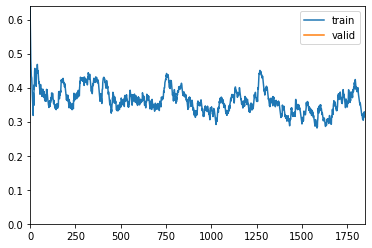

In [ ]:
learner.fit_one_cycle(1,max_lr=1e-4,moms=(0.8,0.7))

In [ ]:
learner.freeze_to(-2)

In [ ]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.233490,0.191846,0.935366,0.064634,11:11


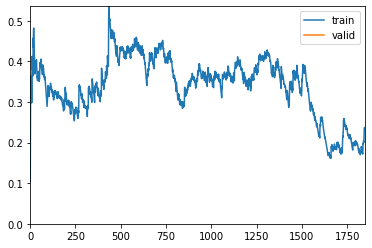

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.249453,0.265247,0.869512,0.130488,12:53


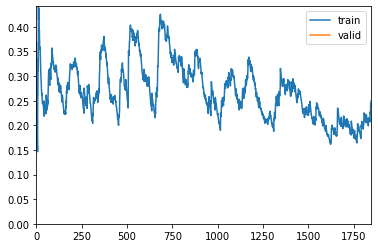

In [ ]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time


RuntimeError: ignored